# Deep Convolutional Generative Adversarial Networks (DCGAN)
Here we will create a variation of a neural network called DCGAN and train it on the image dataset created with the Web Scrapper notebook file.

The structure of the DCGAN model will consist of two pieces. One being the **generator**, a model that generates random synthetic "fake" images based off the training dataset of real images. The other is the **discriminator**, which evaluates the generated images to see if they are real or fake. This becomes the calculated results that show how well the model performed on top of the typical loss function.

## Mount Drive
Mounting Google Drive so it will be accessable in Colab when using the dataset of images as an input.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importing Packages and Libraries
Importing required packages and libraries for the DCGAN model including `numpy`, `matplotlib` and `torch`. PyTorch is the open-source machine learning library that we will use for building, training and testing our neural network model.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import os
import random
import argparse

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

# Variable Declarations
Here is where the user can adjust variables for the preprocessing of the dataset, the structure of the model and optimizers, and the number of model training runs. The variables and are as followed,

`dataset_path` - The directory for where the images dataset is located.

`image_size` - The size that the training images are transformed and resized to. (Ex. 64x64, 128x128, etc.)

`epochs` - Number of training runs or epochs.

`batch` - The batch size for the training.

`learn_rate` - The learning rate for the optimizers.

`beta` - The beta hyperparam for the optimizers.

`ngpu` - Variable for if a GPU is present or not. (1 for GPU, 0 for CPU)

In [3]:
dataset_path = "drive/MyDrive/Colab Notebooks/dataset"

image_size = 64

epochs = 100
batch = 128

learn_rate = 0.0002
beta = 0.5

ngpu = 1

# Transforming the Dataset
Taking the various sized images from the dataset and resizing them to the same size before inputting. A sample plot is shown of the transformed images. As well as setting up the device to be used for the model and dataset.

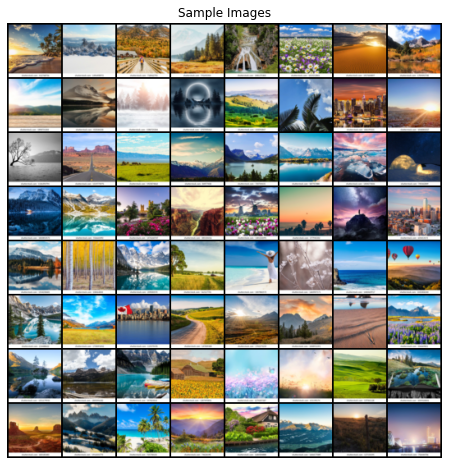

In [4]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

trans_data = dset.ImageFolder(root=dataset_path, transform=transforms.Compose([transforms.Resize(image_size),
                               transforms.CenterCrop(image_size), transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

dataloader = torch.utils.data.DataLoader(trans_data, batch_size=batch, shuffle=True, num_workers=2)
batch_data = next(iter(dataloader))

plt.figure(figsize=(8,8))
plt.title("Sample Images")
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(batch_data[0].to(device)[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))

## Initializing Weights
Creating the weights initialization for the generator and discriminator models.

In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)

    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Generator Model
Generating the generator model with the following architecture,

An input vector *Z* of size 100. No bias terms.

Several transpose 2D convolutions (*512 x 4 x 4 -> 256 x 8 x 8 -> 128 x 16 x 16 -> 64 x 32 x 32*). No bias terms.

Each convolutional layer (except the last one) is equipped with *Batch Normalization* (batch norm), followed by *ReLU*. The last (output) layer is equipped with *tanh* activation (no batch norm).

In [6]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100, 64 * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(64 * 2, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

Creating the generator model. Printing out the model you can see the different layers in its architecture.

In [7]:
gen_model = Generator(ngpu).to(device)

if (device.type == 'cuda') and (ngpu > 1):
    gen_model = nn.DataParallel(gen_model, list(range(ngpu)))

gen_model.apply(weights_init)

print(gen_model)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


## Discriminator Model
Generating the discriminator model with the following architecture, (This is essentially the reverse of a standard generative architecture so the same kernel size can be used):

An input image, in this case size *3x64x64*. No bias terms.

Several transpose 2D convolutions (*64 x 32 x 32 -> 128 x 16 x 16 -> 256 x 8 x 8 -> 512 x 4 x 4*). No bias terms.

Each convolutional layer (except the last one) is equipped with *Batch Normalization* (batch norm), followed by *ReLU*. The last (output) layer is equipped with a *Sigmoid* activation (no batch norm).

In [8]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

Creating the discriminator model. Printing out the model you can see the different layers in its architecture.

In [9]:
dis_model = Discriminator(ngpu).to(device)

if (device.type == 'cuda') and (ngpu > 1):
    dis_model = nn.DataParallel(dis_model, list(range(ngpu)))

dis_model.apply(weights_init)

print(dis_model)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


## BCE Loss Function
Initializing the Binary Cross Entropy loss to visualize how well the model does during training. Setting up the `Adam optimizers` for both the generator and discriminator along with creating latent vectors for the visualization. 

In [10]:
criterion = nn.BCELoss()
vec_noise = torch.randn(64, 100, 1, 1, device=device)

optim_D = optim.Adam(dis_model.parameters(), lr=learn_rate, betas=(beta, 0.999))
optim_G = optim.Adam(gen_model.parameters(), lr=learn_rate, betas=(beta, 0.999))

## Training the Model
With the framework and models completed, and losses initialized, its time to train the models to view the results. Creating lists for tracking, the training loop is based off the number of epochs. For this notebook it was set to 100 epochs for just over 4000 inputted images from the dataset.

For training the generator, we compute the gradient with the backward pass and update the optimizer with each step. As well as compute the generators loss and classify the output for the discriminator.

For training the discriminator, we will construct a batch of real images from the dataset and forward pass it. From there we will calculate the loss and gradient with the backward pass, similiarly to the generator. with the gradient collected from the real and fake batches, we update the step of the optimizer. 

For the output results we have, number of epochs elapsed, the average output of the discriminator **D(x)**, the average of the fake batches **D(G(Z))**, the discriminator loss **Dis_Loss** and the generator loss **Gen_Loss**.


In [11]:
x = 0
gen_loss = []
dis_loss = []
img_list = []

for epoch in range(epochs):
    for i, data in enumerate(dataloader, 0):
        dis_model.zero_grad()

        real_cpu = data[0].to(device)
        label = torch.full((real_cpu.size(0),), 1., dtype=torch.float, device=device)

        output = dis_model(real_cpu).view(-1)

        dis_error_real = criterion(output, label)
        dis_error_real.backward()
        dx = output.mean().item()

        noise = torch.randn(real_cpu.size(0), 100, 1, 1, device=device)

        fake_out = gen_model(noise)
        label.fill_(0.)

        output = dis_model(fake_out.detach()).view(-1)

        dis_error_fake = criterion(output, label)
        dis_error_fake.backward()
        D_G_z1 = output.mean().item()

        dis_error = dis_error_real + dis_error_fake

        optim_D.step()

        gen_model.zero_grad()
        label.fill_(1.)

        output = dis_model(fake_out).view(-1)

        gen_error = criterion(output, label)
        gen_error.backward()
        dgz = output.mean().item()

        optim_G.step()

        if i % 50 == 0:
            print('Epoch: %d/%d | D(x): %.4f | D(G(Z)): %.4f / %.4f | Dis_Loss: %.4f | Gen_Loss: %.4f'
                  % (epoch + 1, epochs, dx, D_G_z1, dgz, dis_error.item(), gen_error.item()))

        gen_loss.append(gen_error.item())
        dis_loss.append(dis_error.item())

        if (x % 500 == 0) or ((epoch == epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake_out = gen_model(vec_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake_out, padding=2, normalize=True))

        x += 1

Epoch: 1/100 | D(x): 0.5250 | D(G(Z)): 0.5643 / 0.0080 | Dis_Loss: 1.8103 | Gen_Loss: 5.2993
Epoch: 2/100 | D(x): 0.9386 | D(G(Z)): 0.0008 / 0.0004 | Dis_Loss: 0.0990 | Gen_Loss: 8.1492
Epoch: 3/100 | D(x): 0.9632 | D(G(Z)): 0.3314 / 0.0000 | Dis_Loss: 0.4832 | Gen_Loss: 18.0954
Epoch: 4/100 | D(x): 0.9875 | D(G(Z)): 0.0000 / 0.0000 | Dis_Loss: 0.0147 | Gen_Loss: 10.7663
Epoch: 5/100 | D(x): 0.9684 | D(G(Z)): 0.0041 / 0.0010 | Dis_Loss: 0.0398 | Gen_Loss: 6.9462
Epoch: 6/100 | D(x): 0.8444 | D(G(Z)): 0.0000 / 0.0000 | Dis_Loss: 0.2770 | Gen_Loss: 22.7409
Epoch: 7/100 | D(x): 0.9023 | D(G(Z)): 0.0168 / 0.0027 | Dis_Loss: 0.1342 | Gen_Loss: 6.8541
Epoch: 8/100 | D(x): 0.8950 | D(G(Z)): 0.1619 / 0.0243 | Dis_Loss: 0.3147 | Gen_Loss: 4.1809
Epoch: 9/100 | D(x): 0.9653 | D(G(Z)): 0.2254 / 0.0062 | Dis_Loss: 0.3390 | Gen_Loss: 6.7429
Epoch: 10/100 | D(x): 0.9579 | D(G(Z)): 0.0223 / 0.0142 | Dis_Loss: 0.0719 | Gen_Loss: 4.5951
Epoch: 11/100 | D(x): 0.9877 | D(G(Z)): 0.8535 / 0.0001 | Dis_Loss

## Visualizing the Results
Here we are plotting the results created after the training run of the models. 

Shown below is the loss curves of the generator and discriminator. What can be observed is how over increased iterations, the two curves begin to converge and level out with one another.

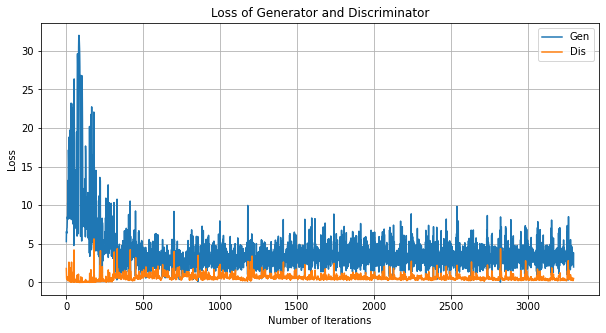

In [12]:
plt.figure(figsize=(10, 5))

plt.title("Loss of Generator and Discriminator")
plt.plot(gen_loss, label="Gen")
plt.plot(dis_loss, label="Dis")

plt.xlabel("Number of Iterations")
plt.ylabel("Loss")

plt.legend()
plt.grid()
plt.show()

Here we grab some fake images and compare them to the real ones to see how well the neural network trained on the dataset. Observed are relatively convincing images, and with more input data and iteration loops can become even better.

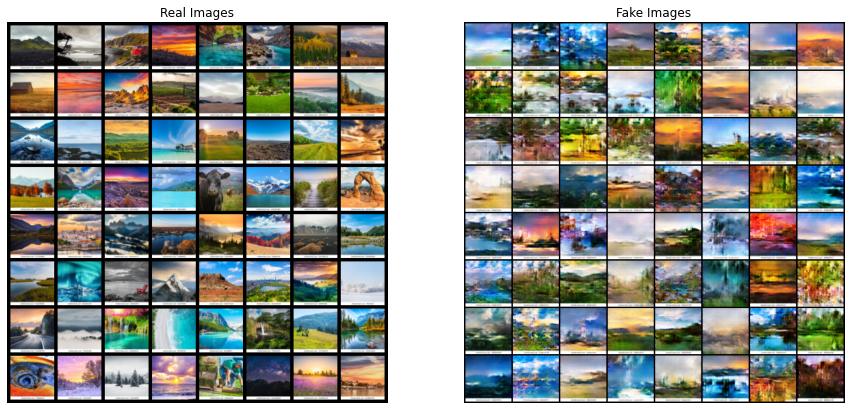

In [13]:
batch_data = next(iter(dataloader))

plt.figure(figsize=(15, 15))

plt.subplot(1, 2, 1)
plt.title("Real Images")
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(batch_data[0].to(device)[:64], padding=5, normalize=True).cpu(), (1, 2, 0)))

plt.subplot(1, 2, 2)
plt.title("Fake Images")
plt.axis("off")
plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))
plt.show()